# Day 23: Coprocessor Conflagration

You decide to head directly to the CPU and fix the printer from there. As you get close, you find an experimental coprocessor doing so much work that the local programs are afraid it will halt and catch fire. This would cause serious issues for the rest of the computer, so you head in and see what you can do.

The code it's running seems to be a variant of the kind you saw recently on that tablet. The general functionality seems very similar, but some of the instructions are different:

- `set X Y` sets register `X` to the value of `Y`.
- `sub X Y` decreases register `X` by the value of `Y`.
- `mul X Y` sets register `X` to the result of multiplying the value contained in register `X` by the value of `Y`.
- `jnz X Y` jumps with an offset of the value of `Y`, but only if the value of `X` is not zero. (An offset of 2 skips the next instruction, an offset of -1 jumps to the previous instruction, and so on.)

Only the instructions listed above are used. The eight registers here, named `a` through `h`, all start at 0.

The coprocessor is currently set to some kind of debug mode, which allows for testing, but prevents it from doing any meaningful work.

In [1]:
import collections, string


def parse(s):
    lines = s.strip().splitlines()
    return [line.split() for line in lines]


REGS = string.ascii_lowercase[:8]


def run(code, regs=None):
    ip = 0
    regs = collections.defaultdict(int, regs if regs else {})

    mul_count = 0

    def get(x):
        if x in REGS:
            return regs[x]
        return int(x)

    while 0 <= ip < len(code):
        line = code[ip]
        cmd, *args = line
        if cmd == 'set':
            regs[args[0]] = get(args[1])
        elif cmd == 'mul':
            regs[args[0]] = get(args[0]) * get(args[1])
            mul_count += 1
        elif cmd == 'sub':
            regs[args[0]] = get(args[0]) - get(args[1])
        elif cmd == 'jnz':
            if get(args[0]):
                ip += get(args[1])
                continue
        else:
            raise NotImplementedError(cmd)
        ip += 1

    return mul_count, regs

If you run the program (your puzzle input), how many times is the `mul` instruction invoked?

In [2]:
puzzle = parse(open('23.input').read())
run(puzzle)[0]

6724

## Part Two

Now, it's time to fix the problem.

The debug mode switch is wired directly to register `a`. You flip the switch, which makes register `a` now start at 1 when the program is executed.

Immediately, the coprocessor begins to overheat. Whoever wrote this program obviously didn't choose a very efficient implementation. You'll need to optimize the program if it has any hope of completing before Santa needs that printer working.

The coprocessor's ultimate goal is to determine the final value left in register `h` once the program completes. Technically, if it had that... it wouldn't even need to run the program.

After setting register `a` to 1, if the program were to run to completion, what value would be left in register `h`?

In [3]:
#run(puzzle, {'a': 1})

Let's create a flow graph.
- Vertices for each line of the code (plus a `start` and `stop` vertex).
- Edges for each transition (optionally annotated by the condition).

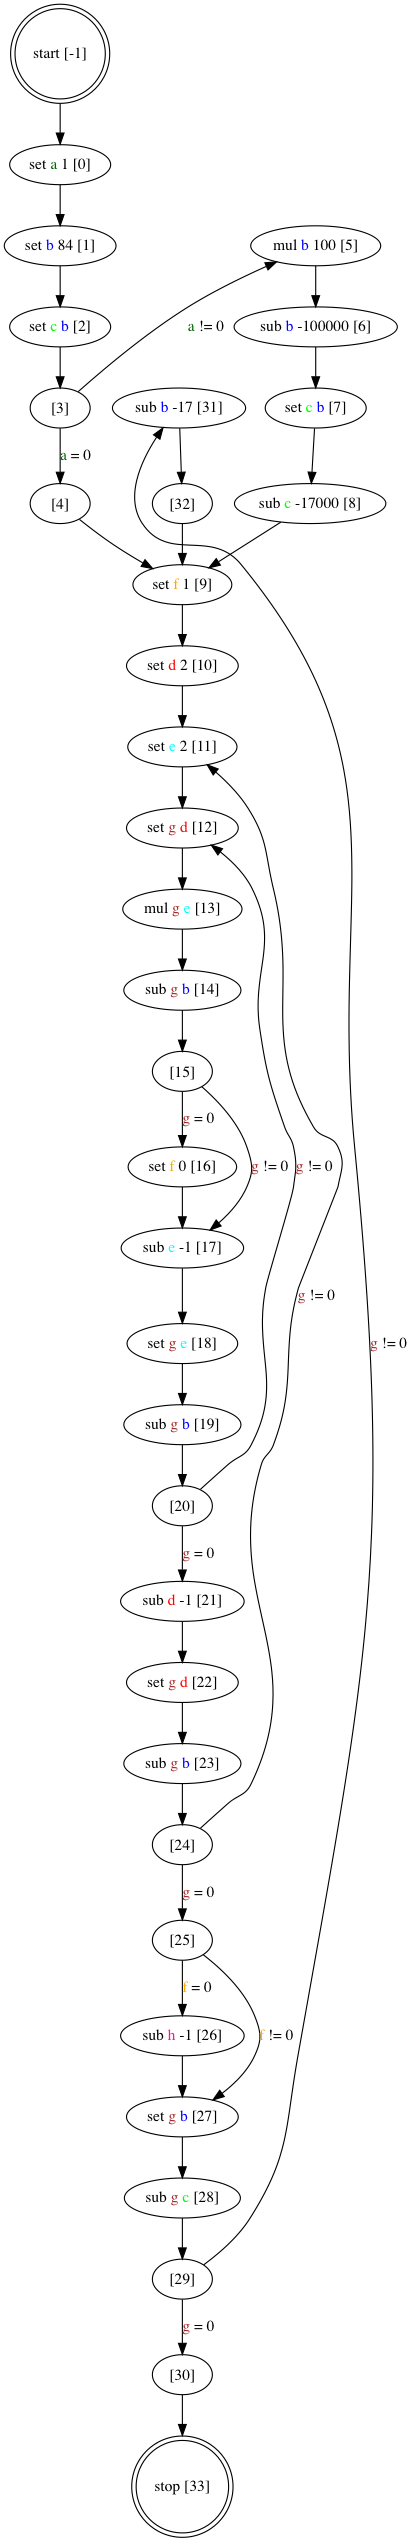

In [4]:
import networkx as nx
from nxpd import draw, nxpdParams
nxpdParams['show'] = 'ipynb'

REG_COLORS = {
    'a': 'darkgreen',
    'b': 'blue',
    'c': 'green',
    'd': 'red',
    'e': 'cyan',
    'f': 'orange',
    'g': 'brown',
    'h': 'deeppink'
}


def color(x):
    if x in REGS:
        return '<font color="%s">%s</font>' % (REG_COLORS[x], x)

    else:
        return '<font color="black">%s</font>' % x


def flowgraph(code):
    G = nx.DiGraph()
    G.graph['dpi'] = 80
    G.add_node(-1, label='<<b>start</b> [-1]>', shape='doublecircle')
    G.add_node(
        len(code),
        label='<<b>stop</b> [%d]>' % len(code),
        shape='doublecircle')
    G.add_edge(-1, 0)
    for i, code in enumerate(code):
        if code[0] == 'jnz':
            G.add_node(i, label='[%d]' % i)
            if code[1] in REGS:
                G.add_edge(i, i + 1, label='<%s = 0>' % color(code[1]))
                G.add_edge(
                    i,
                    i + int(code[2]),
                    label='<%s != 0>' % color(code[1]),
                    constraint='false')
            elif int(code[1]):
                G.add_edge(i, i + int(code[2]))
            else:
                G.add_edge(i, i + 1)
        else:
            G.add_node(
                i,
                label='<%s %s %s [%d]>' % (code[0], color(code[1]),
                                           color(code[2]), i))
            G.add_edge(i, i + 1)
    return G


draw(flowgraph([['set', 'a', '1']] + puzzle))

Optimize code.

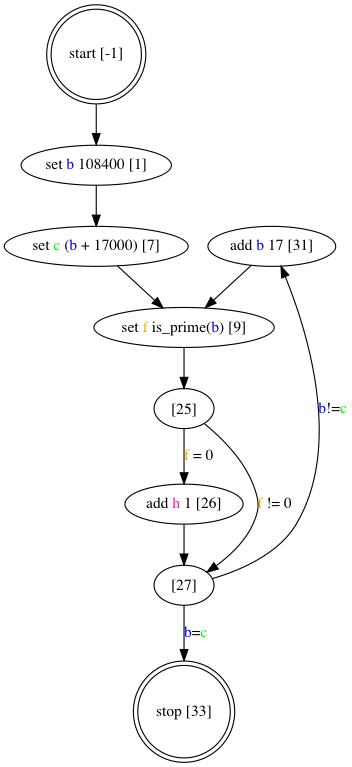

In [5]:
code = [['set', 'a', '1']] + puzzle

G = flowgraph(code)

# register a is always 1, so we can simplify the first branch
G.add_edges_from([(-1, 1), (2, 5)])
G.remove_nodes_from([0, 3, 4])

# remove the two deterministic jumps
G.add_edge(31, 9)
G.remove_node(32)
G.add_edge(29, 33, label=G[29][30]['label'])
G.remove_node(30)

# remove useless assignment
G.remove_node(2)
G.add_edge(1, 5)

# simplify initialization of b and c
G.node[1]['label'] = '<set %s %d [1]>' % (color('b'), 84 * 100 + 100_000)
G.add_edge(1, 7)
G.remove_nodes_from([5, 6])

G.node[7]['label'] = '<set %s (%s + %d) [7]>' % (color('c'), color('b'),
                                                 17_000)
G.add_edge(7, 9)
G.remove_node(8)

# make conditional jumps more meaningful by removing uses of g
G.nodes[27]['label'] = '[27]'
G.add_edge(27, 33, label='<%s=%s>' % (color('b'), color('c')))
G.add_edge(
    27, 31, label='<%s!=%s>' % (color('b'), color('c')), constraint='false')
G.remove_nodes_from([28, 29])

G.nodes[22]['label'] = '[22]'
G.add_edge(22, 25, label='<%s=%s>' % (color('b'), color('d')))
G.add_edge(
    22, 11, label='<%s!=%s>' % (color('b'), color('d')), constraint='false')
G.remove_nodes_from([23, 24])

G.nodes[18]['label'] = '[18]'
G.add_edge(18, 21, label='<%s=%s>' % (color('b'), color('e')))
G.add_edge(
    18, 12, label='<%s!=%s>' % (color('b'), color('e')), constraint='false')
G.remove_nodes_from([19, 20])

G.nodes[12]['label'] = '[12]'
G.add_edge(12, 16, label='<%s=%s %s>' % (color('b'), color('d'), color('e')))
G.add_edge(
    12,
    17,
    label='<%s!=%s %s>' % (color('b'), color('d'), color('e')),
    constraint='false')
G.remove_nodes_from([13, 14, 15])

# sub with minus is add
G.nodes[31]['label'] = '<add %s 17 [31]>' % color('b')
G.nodes[17]['label'] = '<add %s 1 [17]>' % color('e')
G.nodes[21]['label'] = '<add %s 1 [21]>' % color('d')
G.nodes[26]['label'] = '<add %s 1 [26]>' % color('h')

# lines 11-17 set f=0 if d is a divisor of b not equal to b (there exists 2 <= e <= b such that d*e=b)
G.nodes[11]['label'] = '<if %s divides %s and %s != %s: %s = 0 [11]>' % (
    color('d'), color('b'), color('d'), color('b'), color('f'))
G.add_edge(11, 21)
G.remove_nodes_from([12, 16, 17, 18])

# now we see that lines 9-22 set f=0 if b has any nontrivial divisor; i.e. f=1 iff b is a prime
G.nodes[9]['label'] = '<set %s is_prime(%s) [9]>' % (color('f'), color('b'))
G.add_edge(9, 25)
G.remove_nodes_from([10, 11, 21, 22])

draw(G)

Aha! We are counting the number of composite numbers of the form $108400+17k$, $k=0,\dots,1000$:

In [6]:
def is_prime(b):
    for c in range(2, int(b**.5) + 1, 1):
        if b % c == 0:
            return False
    return True


h = sum(1 for b in range(108_400, 108_400 + 17_000 + 1, 17) if not is_prime(b))
h

903